# Query-by-committee

In [3]:
from collections import namedtuple
from modAL.models import Committee, ActiveLearner
from modAL.disagreement import vote_entropy_sampling, consensus_entropy_sampling, max_disagreement_sampling
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from skorch import NeuralNetClassifier
from torchvision import datasets, transforms
from joblib import Parallel, delayed
import itertools as it
from tqdm import tqdm

ResultsRecord = namedtuple('ResultsRecord', ['estimator', 'query_id', 'score'])

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [5]:
# Initialize committee members using skorch
def create_learner():
    net = NeuralNetClassifier(
        SimpleCNN,
        max_epochs=5,
        lr=0.001,
        optimizer=torch.optim.Adam,
        criterion=nn.CrossEntropyLoss,
        device="cuda" if torch.cuda.is_available() else "cpu",
        train_split=None,
        verbose=0,
        iterator_train__shuffle=True,
        module__num_classes=3,
        batch_size=64,
    )
    return ActiveLearner(
        estimator=net,
        query_strategy=vote_entropy_sampling,
        X_training=None,
        y_training=None,
    )

In [6]:
def load_filtered_CIFAR(
    selected_labels, num_train_per_class=200, num_test_per_class=50
):
    train = datasets.CIFAR100(root="./data", train=True, download=True)
    test = datasets.CIFAR100(root="./data", train=False, download=True)

    def filter_data(X, y, n):
        filtered_images = []
        filtered_labels = []

        for i, label in enumerate(selected_labels):
            indices = np.where(y == label)[0][:n]
            filtered_images.append(X[indices])
            filtered_labels.append(np.full(len(indices), i))

        X_filtered = np.concatenate(filtered_images, axis=0).astype(np.float32) / 255.0
        y_filtered = np.concatenate(filtered_labels, axis=0).astype(np.int64)

        # Reshape to (N, C, H, W) format
        X_filtered = X_filtered.transpose(0, 3, 1, 2)

        return X_filtered, y_filtered

    X_train, y_train = filter_data(
        train.data, np.array(train.targets), num_train_per_class
    )
    X_test, y_test = filter_data(test.data, np.array(test.targets), num_test_per_class)

    return X_train, y_train, X_test, y_test

In [7]:
# Setup initial training data and pool
n_initial = 10
selected_labels = [0, 1, 2]
n_classes = len(selected_labels)

In [8]:
# Load and preprocess the data
X_train, y_train, X_test, y_test = load_filtered_CIFAR(selected_labels)

# Convert labels to long tensor type
y_train = y_train.astype(np.int64)  # Convert to int64
y_test = y_test.astype(np.int64)  # Convert to int64

# Randomly select initial training data
initial_indices = np.random.choice(len(X_train), n_initial, replace=False)
X_init = X_train[initial_indices].reshape(-1, 3, 32, 32)
y_init = y_train[initial_indices]

# Create pool of remaining samples
pool_indices = np.setdiff1d(np.arange(len(X_train)), initial_indices)
X_pool = X_train[pool_indices].reshape(-1, 3, 32, 32)
y_pool = y_train[pool_indices]

# Reshape test data
X_test = X_test.reshape(-1, 3, 32, 32)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
def run_active_learning(
    i,
    method_name,
    method,
    committee_size,
    X_train,
    y_train,
    X_test,
    y_test,
    n_initial=10,
    n_queries=50,
    query_batch_size=10,
):

    # Initialize data
    initial_indices = np.random.choice(len(X_train), n_initial, replace=False)
    X_init = X_train[initial_indices]
    y_init = y_train[initial_indices]

    # Create pool
    pool_indices = np.setdiff1d(np.arange(len(X_train)), initial_indices)
    X_pool = X_train[pool_indices]
    y_pool = y_train[pool_indices]

    # Create committee
    committee_members = [create_learner() for _ in range(committee_size)]

    # Initialize committee members
    for learner in committee_members:
        learner.teach(X_init, y_init)

    committee = Committee(
        learner_list=committee_members, query_strategy= method
    )

    performance_history = []
    for idx in tqdm(range(n_queries),desc=f'Points {i} with {method_name}'):
        try:
            predictions = committee.predict(X_test)
            accuracy = np.mean(predictions == y_test)
            performance_history.append(ResultsRecord(
            f'committe_{method_name}',
            idx,
            accuracy))


            print(f"Members: {committee_size}, Query {idx+1}, Accuracy: {accuracy:.4f}")

            query_idx, _ = committee.query(X_pool, n_instances=query_batch_size)
            X_query = X_pool[query_idx]
            y_query = y_pool[query_idx]

            for learner in committee_members:
                learner.teach(X_query, y_query)

            mask = np.ones(len(X_pool), dtype=bool)
            mask[query_idx] = False
            X_pool = X_pool[mask]
            y_pool = y_pool[mask]

        except Exception as e:
            print(f"Error at iteration {idx}: {str(e)}")
            break

    return performance_history

In [10]:
def run_random_sampling(
    X_train, y_train, X_test, y_test, n_initial=10, n_queries=50, query_batch_size=10
):
    # Initialize data
    initial_indices = np.random.choice(len(X_train), n_initial, replace=False)
    X_init = X_train[initial_indices]
    y_init = y_train[initial_indices]

    # Create pool
    pool_indices = np.setdiff1d(np.arange(len(X_train)), initial_indices)
    X_pool = X_train[pool_indices]
    y_pool = y_train[pool_indices]

    # Create single learner
    learner = create_learner()
    learner.teach(X_init, y_init)

    performance_history = []
    for idx in tqdm(range(n_queries)):
        try:
            predictions = learner.predict(X_test)
            accuracy = np.mean(predictions == y_test)
            performance_history.append(accuracy)

            print(f"Random, Query {idx+1}, Accuracy: {accuracy:.4f}")

            query_idx = np.random.choice(len(X_pool), query_batch_size, replace=False)
            X_query = X_pool[query_idx]
            y_query = y_pool[query_idx]

            learner.teach(X_query, y_query)

            mask = np.ones(len(X_pool), dtype=bool)
            mask[query_idx] = False
            X_pool = X_pool[mask]
            y_pool = y_pool[mask]

        except Exception as e:
            print(f"Error at iteration {idx}: {str(e)}")
            break

    return performance_history

In [ ]:
# Load and preprocess data
X_train, y_train, X_test, y_test = load_filtered_CIFAR(selected_labels=[0, 1, 2])

# Run experiments
n_initials = 10
n_queries = 50
committee_size = 4
n_repeats = 2
query_batch_size = 1
disagreement_methods = {"vote_entropy_sampling": vote_entropy_sampling, "consensus_entropy_sampling": consensus_entropy_sampling, "max_disagreement_sampling": max_disagreement_sampling}
results = {}

Files already downloaded and verified
Files already downloaded and verified


In [12]:
# # Run random sampling
# print("Running Random Sampling...")
# results["Random"] = run_random_sampling(
#     X_train, y_train, X_test, y_test, n_queries=n_queries
# )

In [ ]:
# Run QBC with different committee sizes
# for method_name, method in disagreement_methods.items():
#     print(f"\nRunning QBC with {method_name}...")
#     results[f"QBC-{method_name}"] = run_active_learning(
#         method, committee_size, X_train, y_train, X_test, y_test, n_queries=n_queries
#     )

result = Parallel(n_jobs=-1)(delayed(run_active_learning)(i,method_name, method, committee_size, X_train, y_train, X_test, y_test, query_batch_size=query_batch_size, n_queries=n_queries)
                    for i,(method_name,method) in tqdm(it.product(range(n_repeats),disagreement_methods.items())))

6it [00:00, 668.56it/s]


In [14]:
import pandas as pd

df_results = pd.DataFrame([r for rs in result for r in rs])
df_results

,estimator,query_id,score
0,committe_vote_entropy_sampling,0,0.333333
1,committe_vote_entropy_sampling,1,0.466667
2,committe_vote_entropy_sampling,2,0.333333
3,committe_vote_entropy_sampling,3,0.333333
4,committe_vote_entropy_sampling,4,0.340000
...,...,...,...
295,committe_max_disagreement_sampling,45,0.720000
296,committe_max_disagreement_sampling,46,0.753333
297,committe_max_disagreement_sampling,47,0.780000
298,committe_max_disagreement_sampling,48,0.773333


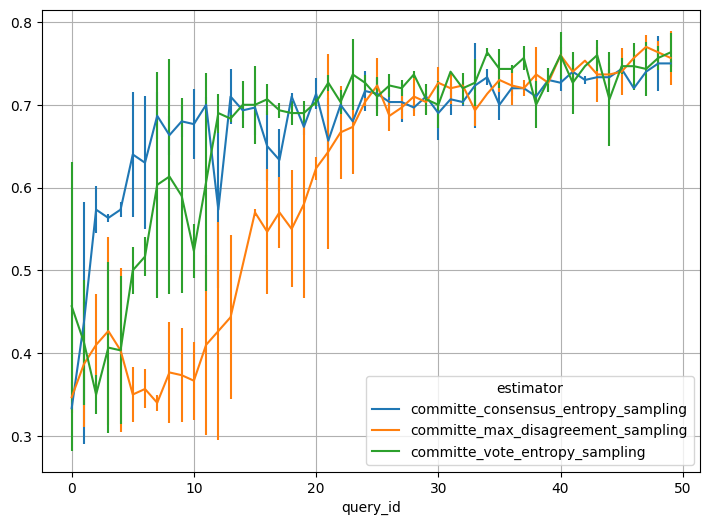

In [15]:
# PANDAS SOLUTION

df_results_mean=df_results.groupby(['estimator','query_id']).mean()
df_results_std=df_results.groupby(['estimator','query_id']).std()

df_mean=df_results_mean.reset_index().pivot(index='query_id', columns='estimator', values='score')
df_std=df_results_std.reset_index().pivot(index='query_id', columns='estimator', values='score')

df_mean.plot(figsize=(8.5,6), yerr=df_std)
plt.grid('on')

In [16]:
df_results.to_csv("data.csv")